## Ensembled Predictions with Uncertainty-Aware Aggregation 

In [25]:
import pandas as pd
import numpy as np
from pathlib import Path
import os
from argparse import ArgumentParser, Namespace
import matplotlib.pyplot as plt
from os.path import basename, dirname, join
from scipy.stats import entropy
from typing import Literal
from scipy.special import softmax
import json
import yaml

import glob

from sklearn.metrics import (
    roc_curve,
    classification_report,
    ConfusionMatrixDisplay,
    RocCurveDisplay,
    confusion_matrix,
    roc_auc_score,
    cohen_kappa_score,
    average_precision_score,
    matthews_corrcoef
)


#### 1. Specify Input Data

In [26]:
## A dictionary to map the dataset names to their respective CSV files.
csv_map = {
    'uni':[f'anonymized_tile_data/uni_{i}.csv' for i in range(5)],
    'virchow':[f'anonymized_tile_data/virchow_{i}.csv' for i in range(5)],
    'conch':[f'anonymized_tile_data/conch_{i}.csv' for i in range(5)],
}
## number of the most confident tile-level predictions to select (we used the top 50% of the tiles)
topK=250    

#### 2. Read csvs

In [27]:
dfs_agg = []
for model, csvs in csv_map.items():
    dfs = [pd.read_csv(csv) for csv in csvs]
    dfs = [df.set_index(['patch','slide','label','subjID']) for df in dfs]
    for i,df in enumerate(dfs):
        if i == 0:
            df_agg = df.copy()
        else:
            df_agg = df_agg.join(df,how='inner',rsuffix=f'_{i}')
    if len(df_agg) == 0:
        raise ValueError('No common tile names between datasets')
    dfs_agg.append(df_agg.reset_index())
df_agg = pd.concat(dfs_agg)

#### 3. Estimate Patch-level Statistics

In [28]:

df_agg = df_agg.reset_index(drop=True).reset_index()
df_agg = df_agg.set_index(['index','subjID','slide','patch','label'],drop=True)

scores = df_agg.mean(axis=1).rename('score')
scores_std = df_agg.std(axis=1).rename('std')
df = pd.concat([scores,scores_std],axis=1).reset_index()

#### 4. Filter out uncertain patches

In [29]:
def filter_topK(df, K=100, col="std",id_col='subjID', ascending=True):
    # if K>1: # K is number
    K=int(K)
    uids = pd.unique(df[id_col])

    subj_dfs = []
    for id in uids:
        # id = str(id)
        subj_df = df.loc[df[id_col] == id]
        subj_df = subj_df.sort_values(by=col, ascending=ascending).reset_index(
            drop=True
        )
        stop_idx = min(K - 1, subj_df.shape[0])
        subj_df = subj_df.loc[:stop_idx]
        subj_dfs.append(subj_df)
    df = pd.concat(subj_dfs, ignore_index=True)
    return df


## filter tiles with lowest uncertainty (top K)
# (if topK is actual count and use macro aggregation,  multiply by number of models)
df = filter_topK(df, K= topK * len(csv_map), col='std',id_col='subjID')

#### 5. Get subject-level predictions


In [30]:
df_subj =  df.groupby(['subjID','label']).mean(numeric_only=True).reset_index()



y_score = df_subj["score"].to_numpy()
y_label = df_subj["label"].to_numpy()
y_pred = np.where(y_score > 0.5, 1, 0)


ROC curve

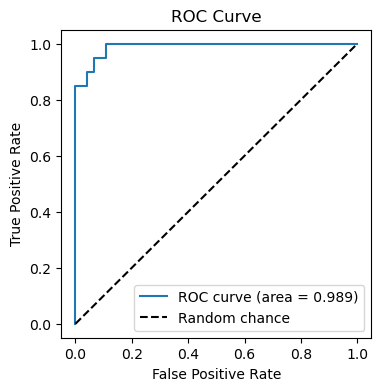

In [31]:
# plot ROC curve
fpr, tpr, thresholds = roc_curve(y_label, y_score, pos_label=1)
plt.figure(figsize=(4, 4))
plt.plot(fpr, tpr, label='ROC curve (area = {:.3f})'.format(roc_auc_score(y_label, y_score)))
plt.plot([0, 1], [0, 1], 'k--', label='Random chance')
# show legend
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()


Performance Metrics

In [32]:
LABEL_DICT = {0: "GBM", 1: "PCNSL","GBM":0,"PCNSL":1}
def detailed_classification_report(y_true, y_score, y_pred, target_names):

    CR = classification_report(y_true, y_pred, output_dict=True,target_names=target_names)

    CR_dict = {
        f'N_{target_names[1]}': CR[LABEL_DICT[1]]['support'],
        f'N_{target_names[0]}': CR[LABEL_DICT[0]]['support'],
        f'Recall_{target_names[1]}': CR[LABEL_DICT[1]]['recall'],
        f'Recall_{target_names[0]}': CR[target_names[0]]['recall'],
        f'Precision_{target_names[1]}': CR[target_names[1]]['precision'],
        f'Precision_{target_names[0]}': CR[target_names[0]]['precision'],
        'Accuracy': CR['accuracy'],
        'Balanced Accuracy': CR['macro avg']['recall'],
        'AUROC': roc_auc_score(y_true, y_score),
        f'AUPRC_{LABEL_DICT[0]}': average_precision_score(y_true,y_score,pos_label=0),
        f'AUPRC_{LABEL_DICT[1]}':  average_precision_score(y_true,y_score,pos_label=1),
        f'F1_{LABEL_DICT[1]}': CR[target_names[1]]['f1-score'],
        f'F1_{LABEL_DICT[0]}': CR[target_names[0]]['f1-score'],
        'Youden''s Index': CR[target_names[1]]['recall']+CR[target_names[0]]['recall']-1,
        'Cohen''s Kappa': cohen_kappa_score(y_true, y_pred),
        'MCC': matthews_corrcoef(y_true, y_pred),
    }
    return CR_dict

target_names = [LABEL_DICT[i] for i in [0, 1]]
CR = detailed_classification_report(y_label, y_score, y_pred, target_names=target_names)
df = pd.DataFrame.from_dict(CR,orient='index', columns=['value'])
print('\n\nClassification Report:\n',df)



Classification Report:
                        value
N_PCNSL            20.000000
N_GBM              75.000000
Recall_PCNSL        0.950000
Recall_GBM          0.933333
Precision_PCNSL     0.791667
Precision_GBM       0.985915
Accuracy            0.936842
Balanced Accuracy   0.941667
AUROC               0.989333
AUPRC_GBM           0.591094
AUPRC_PCNSL         0.968155
F1_PCNSL            0.863636
F1_GBM              0.958904
Youdens Index       0.883333
Cohens Kappa        0.822981
MCC                 0.828773
